### Using wpilib's PID controller - 2021 1212 CJH
#### see other PID notebook for PID basics and a physics-based elevator model
---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import wpilib
from wpilib import controller

### The docstring and various aspects of the PIDController class are explored below
* instantiate by passing three gains, e.g. `test_control = controller.PIDController(Kp=0.01, Ki=0, Kd=0)`
* setpoint is 0 by default, change by `.setSetpoint()`
* get the output from `calculate(current_measurement)`  *you feed it POSITION, not error!*
* it does not clamp to ±1 so you have to do that yourself
* you can force the the integral to be in a range with `setIntegratorRange(min, max)`
* use in combination with the feedforward for better control
https://docs.wpilib.org/en/stable/docs/software/advanced-controls/controllers/feedforward.html

In [7]:
controller.PIDController?

Docstring:      Implements a PID control loop.
Init docstring:
__init__(self: wpilib.controller._controller.PIDController, Kp: float, Ki: float, Kd: float, period: seconds = 0.02) -> None

Allocates a PIDController with the given constants for Kp, Ki, and Kd.

:param Kp:     The proportional coefficient.
:param Ki:     The integral coefficient.
:param Kd:     The derivative coefficient.
:param period: The period between controller updates in seconds. The
               default is 20 milliseconds. Must be non-zero and positive.
File:           c:\users\coryh\miniconda3\lib\site-packages\wpilib\controller\_controller.cp38-win_amd64.pyd
Type:           pybind11_type
Subclasses:     


In [8]:
test_control = controller.PIDController(Kp=0.01, Ki=0, Kd=0)

In [9]:
test_control.getSetpoint()

0.0

In [10]:
test_control.getPositionError()

0.0

In [11]:
test_control.calculate?

Docstring:
calculate(*args, **kwargs)
Overloaded function.

1. calculate(self: wpilib.controller._controller.PIDController, measurement: float) -> float

Returns the next output of the PID controller.

:param measurement: The current measurement of the process variable.

2. calculate(self: wpilib.controller._controller.PIDController, measurement: float, setpoint: float) -> float

Returns the next output of the PID controller.

:param measurement: The current measurement of the process variable.
:param setpoint:    The new setpoint of the controller.
Type:      method


In [12]:
# let's see what the PID controller gives us
controller_attributes = [name for name in dir(test_control) if '_' not in name]
_ = [print(attrib, end=', ') if (ix+1)%8!=0 else print(attrib, end='\n') for ix, attrib in enumerate(controller_attributes) ]

atSetpoint, calculate, disableContinuousInput, enableContinuousInput, getD, getI, getP, getPeriod
getPositionError, getSetpoint, getVelocityError, initSendable, isContinuousInputEnabled, reset, setD, setI
setIntegratorRange, setP, setPID, setSetpoint, setTolerance, 

### Do some simple tests with static models

In [3]:
def clamp(value: float, bottom: float, top: float) -> float:
    return max(bottom, min(value, top))

In [61]:
# Simple data to display in various forms
def get_response(kp, ki, kd, model='const'):
    # make some dummy data
    x = np.linspace(1,100,100)  # call this time, from 0 to 100
    if model == 'const':  # everybody is a 1
        pos = np.ones(len(x))
    elif model == 'sin':  # sine of the time
        pos = np.sin(x/5)
    elif model == 'ramp':  # linear ramp from zero to 1
        pos = x / max(x)
    else:
        raise ValueError('Invalid model: specify const, sin or ramp')
        
    test_control = controller.PIDController(Kp=kp, Ki=ki, Kd=kd)
    test_control.setIntegratorRange(-0.5, 0.5)
    pid_response = [clamp(test_control.calculate(ix), -1, 1) for ix in pos]
    return x, pos, pid_response

In [62]:
# also an example of how to use **kwargs
def plot_responses(gain_dict_1, gain_dict_2, model='const'):
    
    x, pos, pid_response_1 = get_response(**gain_dict_1, model=model)  # same as kp=gain_dict_1['kp'] etc
    x, pos, pid_response_2 = get_response(**gain_dict_2, model=model)
    
    #start the figure
    fig = plt.figure(figsize=(12,8))
    # set height ratios for subplots
    gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1]) 

    # the first subplot - position vs time
    ax1 = plt.subplot(gs[0])
    line_1, = ax1.plot(x, pos, color='g', label='position')
    ax1.axhline(y=0, color='g', lw=1, linestyle='--', label='setpoint')

    # the second subplot 
    # shared axis X
    ax2 = plt.subplot(gs[1], sharex = ax1)
    line_2, = ax2.plot(x, pid_response_1, color='b', linestyle='--', label=f"(kp:{gain_dict_1['kp']},ki:{gain_dict_1['ki']},kd:{gain_dict_1['kd']})")
    #plt.setp(ax1.get_xticklabels(), visible=False)

    # the third subplot
    # shared axis X
    ax3 = plt.subplot(gs[2], sharex = ax1)
    kp, ki, kd = 2, 0, 0
    x, pos, pid_response = get_response(**gain_dict_2)
    line_3, = ax3.plot(x, pid_response_2, color='b', linestyle='--', label=f"(kp:{gain_dict_2['kp']},ki:{gain_dict_2['ki']},kd:{gain_dict_2['kd']})")

    # format the chart
    ax1.set_ylabel('measured position', color='g', fontsize=14)
    ax2.set_ylabel('PID output', color='b', fontsize=14, rotation=90, ha='center', labelpad=0)
    ax3.set_ylabel('PID output', color='b', fontsize=14, rotation=90, ha='center', labelpad=0)
    ax3.set_xlabel(f'time', fontsize=14)
    ax2.set_ylim([-1.1,1.1])
    ax3.set_ylim([-1.1,1.1])
    ax2.set_xlabel(f'time', fontsize=14)
    ax1.set_title(f'Proportional (kp only) PID output,  setpoint = 0', fontsize=14)
    #ax1.legend((line_1, line_2), ('position', f'(kp:{kp},ki:{ki},kd:{kd})'), loc='lower left', prop={'size': 12})
    [ax.legend(loc='lower left', prop={'size': 12}) for ax in [ax1, ax2, ax3]]
    # remove vertical gap between subplots
    plt.subplots_adjust(hspace=0)
    plt.show()

### This is how you use the plot
* set up twp gain dictionaries
* use them as input to the `plot_responses()` function
* choose a model to test against - a constant, a sine wave, or a ramp

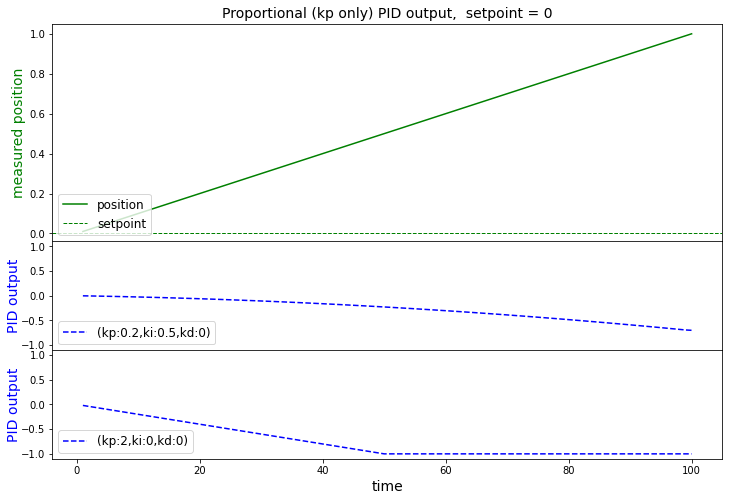

In [60]:
gain_dict_1 = {'kp':0.2, 'ki':0.5, 'kd':0}
gain_dict_2 = {'kp':2, 'ki':0, 'kd':0}
plot_responses(gain_dict_1, gain_dict_2, model='ramp')